<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use *k-fold cross-validation*, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.


### Here's What We Will Be Doing:

* Working with bikeshare data to predict total ridership
* Create a test-train split of the data.
* Evaluate each of the models using `k-fold` cross-validation and select the best model.
* Train each of your models on the full training data.
* Finally test the best models on the testing data set and rank their performance.


**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Use Case

We'll be working with a data set from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Use a slightly different research design to forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another, as sometimes bikeshare stations have no bikes or are completely full and prevent use of the station.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google Trends to improve prediction in these small locations.

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [116]:
bikes = pd.read_csv("./data/bikeshare.csv", index_col="datetime", parse_dates=True)

We have shown some exploratory data analysis and linear regression modelling in `session 10: linear_regression_practical` notebook. Your task is to perform further exploration, improve the model, and train additional models.

### Clean Up Data and Perform Exporatory Data Analysis

Perform exploratory data analysis (EDA).

Include: total nulls, index, data types, shape / distribution, summary statistics, number of unique values for each column, data visualization, correlation matrix.

In [117]:
bikes
print (bikes.isnull().sum())


season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


In [118]:
bikes

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


In [119]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


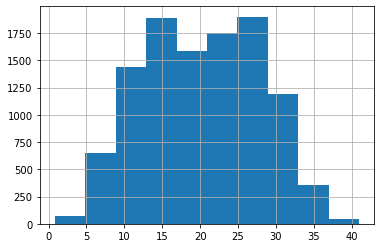

In [120]:
bikes.temp.hist()

In [121]:
for x in bikes.columns:
    print (bikes[x].value_counts())

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
14.76    467
26.24    453
28.70    427
13.94    413
18.86    406
22.14    403
25.42    403
16.40    400
22.96    395
27.06    394
24.60    390
12.30    385
21.32    362
13.12    356
17.22    356
29.52    353
10.66    332
18.04    328
20.50    327
30.34    299
9.84     294
15.58    255
9.02     248
31.16    242
8.20     229
27.88    224
23.78    203
32.80    202
11.48    181
19.68    170
6.56     146
33.62    130
5.74     107
7.38     106
31.98     98
34.44     80
35.26     76
4.92      60
36.90     46
4.10      44
37.72     34
36.08     23
3.28      11
38.54      7
0.82       7
39.36      6
2.46       5
1.64       2
41.00      1
Name: temp, dtype: int64
31.060    671
25.760    423
22.725    406
20.455    400
26.515    395
16.665    381
25.000    365
33.3

In [128]:

q1 = bikes['count'].quantile(0.25)
q3 = bikes['count'].quantile(0.75)
iqr = q3-q1
upper = bikes['count'].mean() + 1.5*iqr
bikes.loc[bikes['count']>upper, 'count'] = bikes['count'].mean()

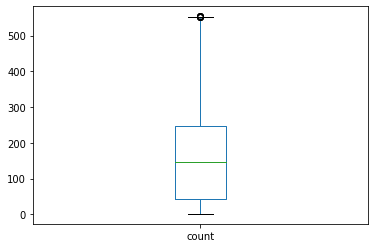

In [129]:
bikes['count'].plot(kind='box')

In [130]:
bikes.corr() #no multicollinearity

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_group
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.167121,0.167335
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,0.014936,-0.001714
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,-0.018718,-0.001085
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.121382,-0.119767
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.381059,0.394925
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.378354,0.390787
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.306293,-0.341234
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.100554,0.119170
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.609523,0.641140
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.744610,0.840818


In [131]:
#bucketize the count
q1 = bikes['count'].quantile(0.25)
q2 = bikes['count'].quantile(0.5)
q3 = bikes['count'].quantile(0.75)
bikes['count_group'] =bikes['count'].apply(lambda x: np.where((x<q1), 1, np.where((x<q2), 2, np.where((x<q3), 3, 4))))
bikes

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_group
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16.0,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40.0,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32.0,1
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13.0,1
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336.0,4
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241.0,3
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168.0,3


### Pre-processing

1. Remove `casual` and `registered` from the dataframe as they are part of the target / response, hence you cannot use them as features!
2. Pre-process some of your features, for example categorical `dummy-encoding`, [standardization](https://scikit-learn.org/stable/modules/preprocessing.html) of features (optional).

In [132]:
bikes.season.unique()

array([1, 2, 3, 4], dtype=int64)

In [134]:
season_list = bikes.season.tolist()
season_dummies = pd.get_dummies(season_list)
season_dummies.columns = ['season_1', 'season_2', 'season_3', 'season_4']
season_dummies.index = bikes.index
bikes_sd = bikes.join(season_dummies)
bikes_sd.drop (columns = 'season' , inplace=True)
bikes_sd


,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_group,season_1,season_2,season_3,season_4
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,1,9.84,14.395,81,0.0000,3,13,16.0,1,1,0,0,0
2011-01-01 01:00:00,0,0,1,9.02,13.635,80,0.0000,8,32,40.0,1,1,0,0,0
2011-01-01 02:00:00,0,0,1,9.02,13.635,80,0.0000,5,27,32.0,1,1,0,0,0
2011-01-01 03:00:00,0,0,1,9.84,14.395,75,0.0000,3,10,13.0,1,1,0,0,0
2011-01-01 04:00:00,0,0,1,9.84,14.395,75,0.0000,0,1,1.0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0,1,1,15.58,19.695,50,26.0027,7,329,336.0,4,0,0,0,1
2012-12-19 20:00:00,0,1,1,14.76,17.425,57,15.0013,10,231,241.0,3,0,0,0,1
2012-12-19 21:00:00,0,1,1,13.94,15.910,61,15.0013,4,164,168.0,3,0,0,0,1


### Feature Engineering

Generate more features, such as 
* hour: as a single numeric feature (0 through 23)
* hour: as a categorical feature (use 23 dummy variables)
* daytime: as a single categorical feature (daytime=1 from 7 a.m. to 8 p.m., and daytime=0 otherwise)
* day of week: Mon - Sun

Get creative and create your own features!!

In [135]:
bikes['hour'] = bikes.index.hour
bikes
bikes['daytime'] = bikes.hour.apply(lambda x : 1 if (x>=7 and x<=20) else 0)
bikes

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_group,hour,daytime
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16.0,1,0,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40.0,1,1,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32.0,1,2,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13.0,1,3,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1.0,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336.0,4,19,1
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241.0,3,20,1
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168.0,3,21,0


### Train/test splits

Instead of using scikit-learn's `train_test_split`, here we split the data into train/test sets based on date, so that it's more reflective of reality, where you only use your model to predict on "future" data, which is the test (holdout) set.

Here, we do a 50/50 split, where the train set is the year of `2011`, while test set is the year of `2012`.

In [136]:
bikes_train = bikes[bikes.index < "2012-01-01"]
bikes_test = bikes[bikes.index >= "2012-01-01"]

In [137]:
bikes_train.shape

(5422, 14)

In [138]:
bikes_test.shape

(5464, 14)

> For all sections below, only train / fit your model on the "train" dataset `bikes_train`, and not the full `bikes` dataset!!

## Using `scikit-learn` Linear Regression

Can you fit 3 different linear regression models (different combination of features) using scikit-learn? 

Then evaluate each of them using K-Fold cross-validation on your training dataset.

What number of `k` seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your cross-validation score. What are the tradeoffs associated with choosing the number of folds?

In [139]:
from sklearn.linear_model import LinearRegression

feature1= [ 'hour', 'daytime', 'temp', 'workingday']
feature2= ['holiday', 'temp', 'humidity', 'daytime', 'windspeed']

X_train = bikes_train[feature1]
y_train = bikes_train['count']

X_test = bikes_test[feature1]
y_test = bikes_test['count']

linreg = LinearRegression()
linreg.fit(X_train,y_train)
print (linreg.predict(X_train))
linreg.score(X_train,y_train)


[-20.82162458 -21.52368742 -17.82238126 ...  72.11874866  75.82005481
  79.52136097]


0.5260657884036875

In [140]:

from sklearn.model_selection import cross_val_score
scores = cross_val_score(linreg, X_train,y_train, cv=5, scoring = 'r2')
print (scores)
scores.mean()


[-1.02753409  0.52055003  0.50679146  0.51199741  0.37669039]


0.17769904181003862

# Using Statsmodels Formula

### Build 3 different models using Statsmodels Formula

Can you fit 3 different linear regression models (different variables / formula) using statsmodels formula? And evaluate each of them using K-Fold cross-validation (the same k-fold from above).

*Try to include one model with interaction effect.*

## Regularized regression

### Build 2 Ridge Regression models with different alpha using Scikit-learn

Can you fit 2 ridge regression models (with different `alpha`)? And evaluate each of them using K-Fold cross-validation (the same k-fold from above).

In [141]:
from sklearn.linear_model import Ridge
import numpy as np
ridge = Ridge(alpha=2.0)
ridge.fit(X_train, y_train)
Ridge.score(ridge, X_train, y_train)

0.5260651670493118

In [142]:
scores = cross_val_score(ridge, X_train,y_train, cv=5, scoring = 'r2')
print (scores)
scores.mean()

[-1.02339939  0.5206241   0.50662165  0.51179401  0.37645138]


0.17841834916917376

### Build 2 Lasso Regression models with different alpha using Scikit-learn

Can you fit 2 lasso regression models (with different `alpha`)? And evaluate each of them using K-Fold cross-validation (the same k-fold from above).

In [143]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 3.0)
lasso.fit(X_train, y_train)
Lasso.score(lasso, X_train, y_train)

0.5218318953277965

In [144]:
scores = cross_val_score(lasso, X_train,y_train, cv=5, scoring = 'r2')
print (scores)
scores.mean()

[-0.83941482  0.52093656  0.49145432  0.49505806  0.35906325]


0.20541947345799008

### Build 2 Elastic-net models with different alpha using Scikit-learn

Can you fit 2 elastic-net regression models (with different `alpha` and `l1_ratio`)? And evaluate each of them using K-Fold cross-validation (the same k-fold from above).

In [145]:
from sklearn.linear_model import ElasticNet
elastic = ElasticNet(alpha = 1.0)
elastic.fit(X_train, y_train)
ElasticNet.score(elastic, X_train, y_train)

0.42289012632738004

In [146]:
scores = cross_val_score(elastic, X_train,y_train, cv=5, scoring = 'r2')
print (scores)
scores.mean()

[-0.34612145  0.42124178  0.37602347  0.36470603  0.20400572]


0.20397110968118587

## k-Nearest Neighbour

### Build 3 different models using k-NN in Scikit-learn
Can you fit 3 different knn models (different variables or k) using scikit-learn? And evaluate each of them using K-Fold cross-validation (the same k-fold from above).

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,daytime,count_group
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0000,3.0,13.0,16.0,0,0,1
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,8.0,32.0,40.0,1,0,1
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0000,5.0,27.0,32.0,2,0,1
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,3.0,10.0,13.0,3,0,1
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0000,0.0,1.0,1.0,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4.0,0.0,1.0,1.0,15.58,19.695,50.0,26.0027,7.0,329.0,336.0,19,1,4
2012-12-19 20:00:00,4.0,0.0,1.0,1.0,14.76,17.425,57.0,15.0013,10.0,231.0,241.0,20,1,4
2012-12-19 21:00:00,4.0,0.0,1.0,1.0,13.94,15.910,61.0,15.0013,4.0,164.0,168.0,21,0,3


In [147]:
X_train = bikes_train[feature1]
y_train = bikes_train['count_group']

X_test = bikes_test[feature1]
y_test = bikes_test['count_group']

In [166]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_train)
y_pred_class



array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

In [167]:
print ((metrics.accuracy_score(y_train, y_pred_class)))

0.8035780154924382


In [168]:
KNeighborsClassifier.score(knn,X_train, y_train )# same result as above

0.8035780154924382

In [151]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100.
scores=[]
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_train)
    score=float(sum(y_train==y_pred_class)/len(y_train))
    scores.append([k,score])

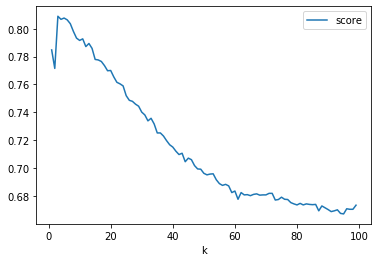

In [152]:
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

In [169]:
scores = cross_val_score(knn, X_train,y_train, cv=5, scoring = 'accuracy')
print (scores)
scores.mean()

[0.63133641 0.69400922 0.7398524  0.71863469 0.59686347]


0.6761392351250702

## Validation on test (holdout) set

Using the best model (with the best cross-validation score) from each of the previous sections (sklearn linear regression, statsmodels linear regression, sklearn regularized regression, sklearn knn), train each of the 4 models on the full training dataset `bikes_train`, and predict on the test set `bikes_test`. Evaluate and rank each of the model based on their accuracy/error on test set. How do they compare with the cross-validation scores?

In [170]:
knn.fit(X_test, y_test)
y_pred_class = knn.predict(X_test)
y_pred_class
print ((metrics.accuracy_score(y_test, y_pred_class)))

0.7941068814055637
